In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping
    

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

import copy

train_on_gpu = torch.cuda.is_available()

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()])

In [4]:
full_data = VowelConsonantDataset("../input/train/train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=60, shuffle=True)

In [5]:
test_data = VowelConsonantDataset("../input/test/test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=60,shuffle=False)

In [6]:
from torchvision import models

In [7]:
resnet_vocab = models.resnet18(pretrained=True)
resnet_const = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.torch/models/resnet18-5c106cde.pth
46827520it [00:13, 3545414.30it/s]


In [8]:
num_classes = 10

In [9]:
for param in resnet_vocab.parameters():
    param.requires_grad = False
    
for param in resnet_const.parameters():
    param.requires_grad = False

In [10]:
torch.empty(2,10)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  4.5793e-41, -3.3615e-26,
          4.5793e-41, -1.4979e-24,  4.5793e-41,  1.4013e-45,  6.9001e-07],
        [ 0.0000e+00,  0.0000e+00,  2.1159e+23,  4.1765e-08,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [11]:
in_features = resnet_vocab.fc.in_features
resnet_vocab.fc = nn.Linear(in_features,10)

in_features = resnet_const.fc.in_features
resnet_const.fc = nn.Linear(in_features,10)



In [12]:
for param in resnet_vocab.parameters():
    if param.requires_grad:
        print(param.shape)

for param in resnet_const.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])
torch.Size([10, 512])
torch.Size([10])


In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
resnet_vocab = resnet_vocab.to(device)
resnet_const = resnet_const.to(device)
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCELoss()
#loss_fn = nn.BCEWithLogitsLoss()
opt_vocab = optim.SGD(resnet_vocab.parameters(), lr=0.01)
opt_const = optim.SGD(resnet_const.parameters(), lr=0.01)

In [15]:
batch_size = 60 

In [16]:
vocab_idx = torch.LongTensor([0])
const_idx = torch.LongTensor([1])

def evaluation(dataloader, model):
    total_vocab, total_const, correct_vocab, correct_const  = 0, 0, 0 , 0
    for data in dataloader:
        inputs_vocab, labels_vocab = data
        inputs_const, labels_const = data
        labels_vocab = labels_vocab.index_select(1, vocab_idx).to(dtype=torch.long).squeeze()
        labels_const = labels_const.index_select(1, const_idx).to(dtype=torch.long).squeeze()
        labels_vocab = torch.argmax(labels_vocab, 1)
        labels_const = torch.argmax(labels_const, 1)
        inputs_vocab,inputs_const,labels_vocab,labels_const = inputs_vocab.to(device),inputs_const.to(device),labels_vocab.to(device),labels_const.to(device)
        
        outputs_vocab = model(inputs_vocab)
        outputs_const = model(inputs_const)
        _, pred_vocab = torch.max(outputs_vocab.data, 1)
        _, pred_const = torch.max(outputs_const.data, 1)
        total_vocab += labels_vocab.size(0)
        total_const += labels_const.size(0)
        correct_vocab += (pred_vocab == labels_vocab).sum().item()
        correct_const += (pred_const == labels_const).sum().item()
    return 100 * (correct_vocab + correct_const) / (total_vocab + total_const)

Min loss 4.71
Iteration: 0/834, Loss: 4.71
Min loss 4.63
Min loss 4.62
Min loss 4.61
Min loss 4.58
Min loss 4.56
Min loss 4.56
Iteration: 100/834, Loss: 4.60
Min loss 4.54
Epoch: 0/1, Test acc: 12.55, Train acc: 11.84
Epoch: 0/1, Test acc: 10.20, Train acc: 11.94


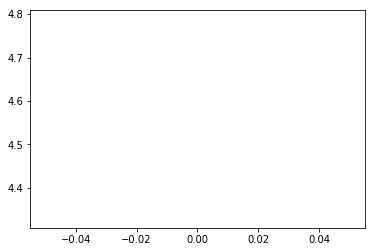

In [17]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

vocab_idx = torch.LongTensor([0])
const_idx = torch.LongTensor([1])

for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0):

        inputs_vocab, labels_vocab = data
        inputs_const, labels_const = data
        labels_vocab = labels_vocab.index_select(1, vocab_idx).to(dtype=torch.long).squeeze()
        labels_const = labels_const.index_select(1, const_idx).to(dtype=torch.long).squeeze()
        labels_vocab = torch.argmax(labels_vocab, 1)
        labels_const = torch.argmax(labels_const, 1)
        inputs_vocab,inputs_const,labels_vocab,labels_const = inputs_vocab.to(device),inputs_const.to(device),labels_vocab.to(device),labels_const.to(device)
        
        opt_vocab.zero_grad()
        opt_const.zero_grad()

        outputs_vocab = resnet_vocab(inputs_vocab)
        outputs_const = resnet_const(inputs_const)
        loss_vocab = loss_fn(torch.sigmoid(outputs_vocab), labels_vocab)
        loss_const = loss_fn(torch.sigmoid(outputs_const), labels_const)
        loss = loss_vocab + loss_const
        loss.backward()
        opt_vocab.step()
        opt_const.step()
        
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model_vocab = copy.deepcopy(resnet_vocab.state_dict())
            best_model_const= copy.deepcopy(resnet_const.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs_vocab, inputs_const, labels_vocab,labels_const,outputs_vocab,outputs_const
        #torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(validation_loader, resnet_vocab), evaluation(train_loader, resnet_vocab)))
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(validation_loader, resnet_const), evaluation(train_loader, resnet_const)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [18]:
dict_vocab = {0:'V0',1:'V1',2:'V2',3:'V3',4:'V4',5:'V5',6:'V6',7:'V7',8:'V8',9:'V9'}
dict_const = {0:'C0',1:'C1',2:'C2',3:'C3',4:'C4',5:'C5',6:'C6',7:'C7',8:'C8',9:'C9'}
print(dict_vocab,dict_const)

{0: 'V0', 1: 'V1', 2: 'V2', 3: 'V3', 4: 'V4', 5: 'V5', 6: 'V6', 7: 'V7', 8: 'V8', 9: 'V9'} {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7', 8: 'C8', 9: 'C9'}


In [19]:
image_List = []
class_List = []
for i, data in enumerate(test_loader, 0):
  images, labels = data
  images = images.to(device)
  results_vocab = resnet_vocab(images)
  results_const = resnet_const(images)
  _, predicted_vocab = torch.max(results_vocab, 1)
  _, predicted_const = torch.max(results_const, 1)
  
  predicted_vocab = list(map(lambda x : dict_vocab[int(x)], predicted_vocab))
  predicted_const = list(map(lambda x : dict_const[int(x)], predicted_const))
  for label, vocab, const in zip(labels, predicted_vocab, predicted_const):
    predict_class = vocab +'_'+ const
    image_List.append(label)
    class_List.append(predict_class)
    
    

In [20]:
submission = {}
submission['ImageId'] = image_List
submission['Class'] = class_List
submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submisision.csv", index=False)

In [21]:
submission

,ImageId,Class
1297,1.png,V5_C8
7929,10.png,V9_C3
8865,100.png,V0_C5
1749,1000.png,V4_C5
7364,10000.png,V5_C4
126,1001.png,V7_C6
8378,1002.png,V6_C4
3369,1003.png,V2_C6
3339,1004.png,V5_C2
9515,1005.png,V9_C4
